In [4]:
import pandas as pd
df = pd.read_csv("/home/pravin/litepool/litepool/rltrader/temp.csv")
df.shape

(1071, 8)

In [5]:
dd = df[['mid', 'balance', 'upnl', 'fees']]
dd['balance'] -= 0.9

/tmp/ipykernel_426304/629390992.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dd['balance'] -= 0.9


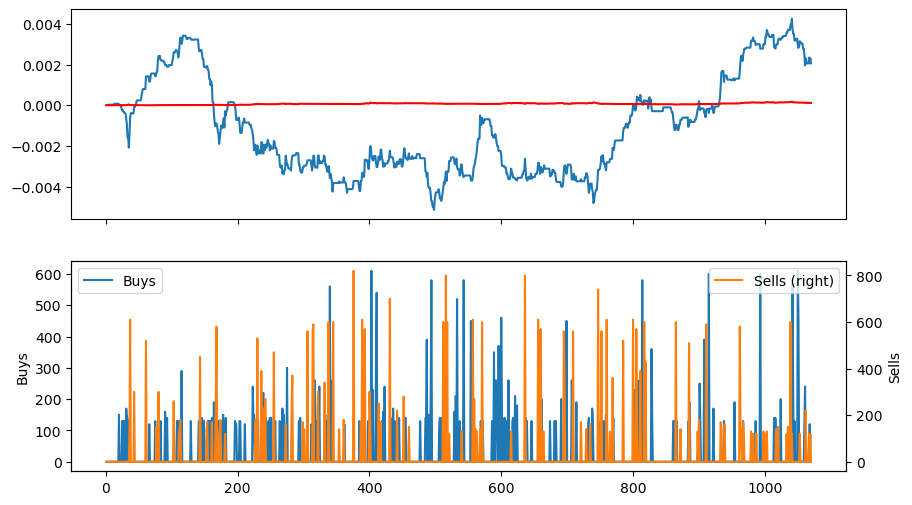

In [11]:
import matplotlib.pyplot as plt
import numpy as np
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 20))
dd['mid'].pct_change().dropna().cumsum().plot(label='BTC', figsize=(10, 6), ax=ax1)
(dd['balance'] + dd['upnl']).pct_change().dropna().cumsum().plot(label='Strategy', ax=ax1, color='red')

df['buy_amount'].diff().dropna().plot(label="Buys", ax=ax2)
df['sell_amount'].diff().dropna().plot(label='Sells', secondary_y=True, ax=ax2)
ax2.set_ylabel('Buys')
ax2.right_ax.set_ylabel('Sells')
ax2.legend(loc='upper left')
ax2.right_ax.legend(loc='upper right')
plt.show()

<Axes: >

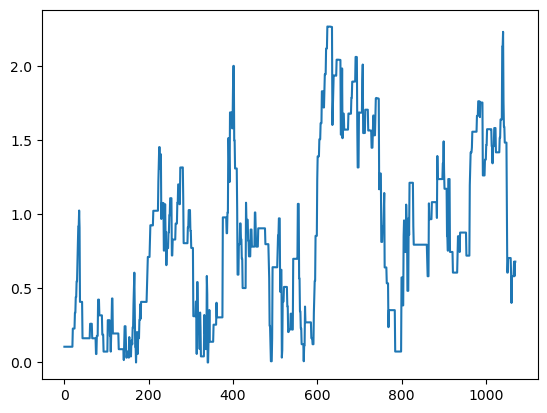

In [7]:
(df['leverage']).plot()

<Axes: >

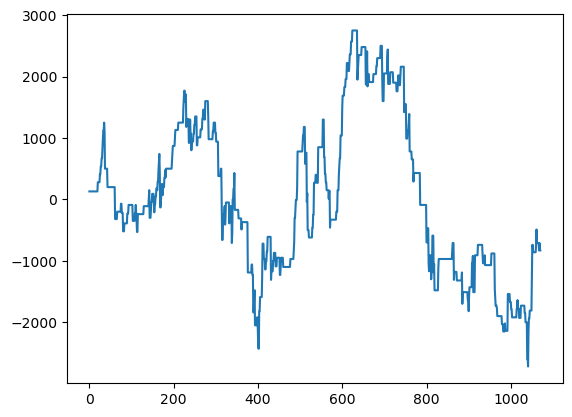

In [8]:
(df['buy_amount'] - df['sell_amount']).plot()

<Axes: >

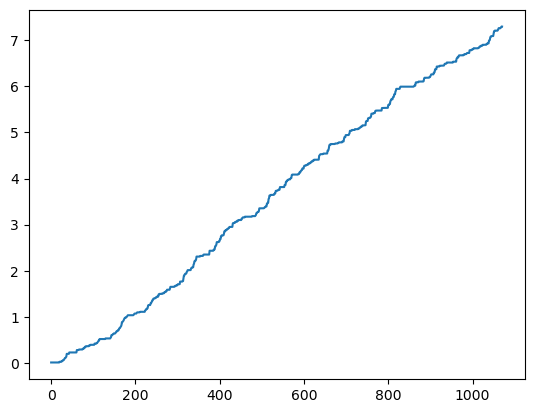

In [9]:
(df['fees'] * df['mid']).plot()

<Axes: >

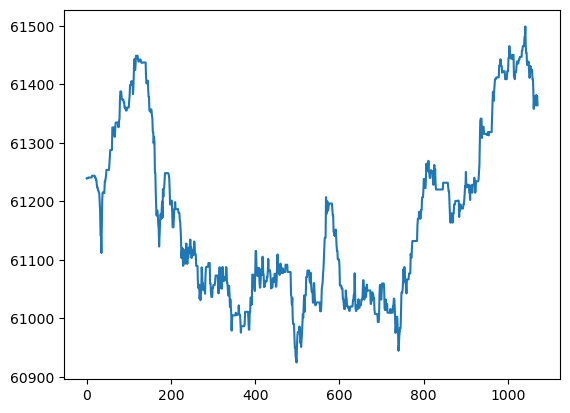

In [10]:
df['mid'].plot()